本コンペは日次の野菜卸売価格の予測タスクですが、ここでは簡単のため、月次の予測タスクに読み替えてみます（日毎に予測値は変えない）<br>
本notebookでは学習・推論を行います。前のnotebookで前処理を行った後、実行してください

In [2]:
# コンペデータを格納しているパスを指定ください
from pathlib import Path
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
sns.set(font="IPAexGothic")
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
def root_mean_squared_percentage_error(true_y, pred_y):
    return np.sqrt(np.mean(((pred_y - true_y) / true_y)**2))*100

In [3]:
train_df = pd.read_csv('data/tutorial_preprocessed_train.csv')
test_df = pd.read_csv('data/tutorial_preprocessed_test.csv')

train_df['year'] = train_df['date']//10000
test_df['year'] = test_df['date']//10000
train_df['month'] = train_df['date'].apply(lambda x: int(str(x)[4:6]))
test_df['month'] = test_df['date'].apply(lambda x: int(str(x)[4:6]))

kinds = test_df['kind'].unique()
train_df = train_df[train_df['kind'].isin(kinds)]

予測モデルを構築します。<br>
LightGBMを使用します。比較のため、前月の値をそのまま予測値としたルールベースモデルも構築します

また、目的変数自身の1,2,3,6,9,12ヶ月前の値もラグ特徴量として取り入れます

In [8]:
SEED = 0

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}

In [9]:
# モデルベースの予測値
result = []
model_dict = {}
pred_df_dict = {}
feature_imp_dict = {}
tra_df_dict = {}

for kind in kinds:
    print(kind)
    ext_df = mer_df[mer_df['kind'] == kind]
    gb_df = ext_df.groupby(['year','month'])[agg_cols].mean().reset_index()
    gb_df[TARGET] = gb_df[TARGET].replace(0,np.nan)

    # 過去の値を特徴量とする
    for i in [1,2,3,6,9,12]:
        gb_df[f'{TARGET}_{i}prev'] = gb_df[TARGET].shift(i)

    test_df = gb_df.query('year == 2022 & month == 11')
    train_df = gb_df.query('~(year == 2022 & month == 11)')
    train_df = train_df.query('year >= 2015') # 2015年以降のデータで学習
    train_df = train_df[train_df[TARGET].notnull()]

    cat_cols = []
    num_cols = [i for i in train_df.columns if i not in [TARGET, 'year', 'month', 'index', 'amount']]
    feat_cols = cat_cols + num_cols

    all_df = pd.concat([train_df, test_df])
    all_df[feat_cols] = all_df[feat_cols].fillna(method='bfill')
    all_df[feat_cols] = all_df[feat_cols].fillna(method='ffill')
    all_df[feat_cols] = all_df[feat_cols].fillna(0)
    train_df = all_df.iloc[:-1,:]
    test_df = all_df.iloc[-1:,:]
    
    # バリデーションはHold-out法（一定割合で学習データと評価データの2つに分割）で行う

    tra_df = train_df.iloc[:-1]
    val_df = train_df.iloc[-1:] # trainの最後の月をvalデータとする

    tra_x = tra_df[feat_cols]
    tra_y = tra_df[TARGET]
    val_x = val_df[feat_cols]
    val_y = val_df[TARGET]
    test_x = test_df[feat_cols]
    test_y = test_df[TARGET]

    tra_data = lgb.Dataset(tra_x, label=tra_y)
    val_data = lgb.Dataset(val_x, label=val_y)

    model = lgb.train(
        params,
        tra_data, 
        categorical_feature = cat_cols,
        valid_names = ['train', 'valid'],
        valid_sets =[tra_data, val_data], 
        verbose_eval = 100,
    )

    val_pred = model.predict(val_x, num_iteration=model.best_iteration)

    pred_df = pd.DataFrame(sorted(zip(val_x.index, val_pred, val_y)), columns=['index', 'predict', 'actual'])

    feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), tra_x.columns)), columns=['importance', 'feature'])

    test_pred = model.predict(test_x, num_iteration=model.best_iteration)

    result.append([kind,2022,11,test_pred[0]])
    model_dict[kind] = model
    pred_df_dict[kind] = pred_df
    feature_imp_dict[kind] = feature_imp
    tra_df_dict[kind] = tra_df

だいこん


NameError: name 'mer_df' is not defined

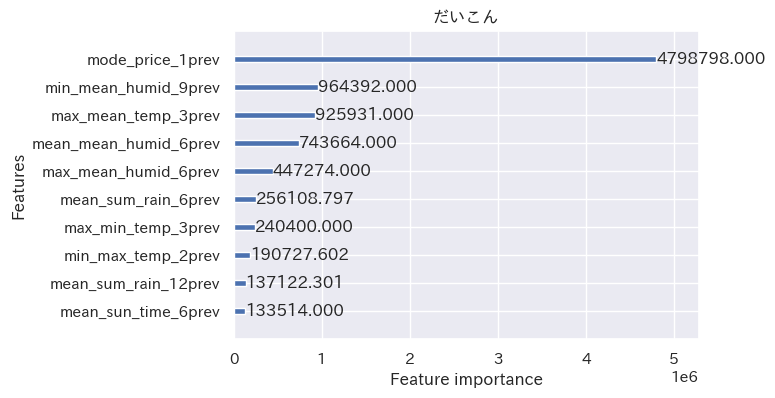

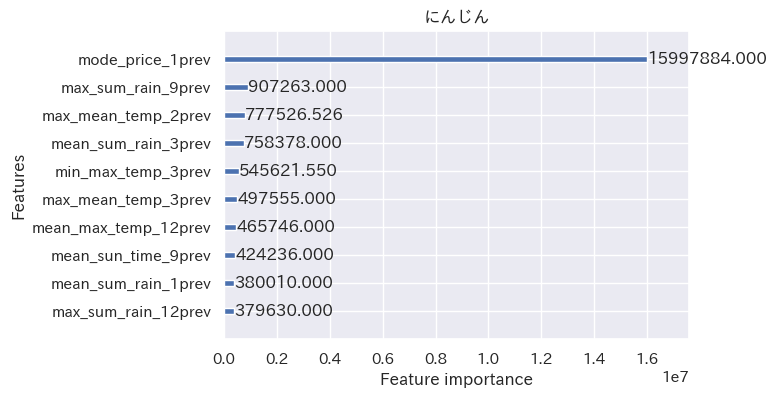

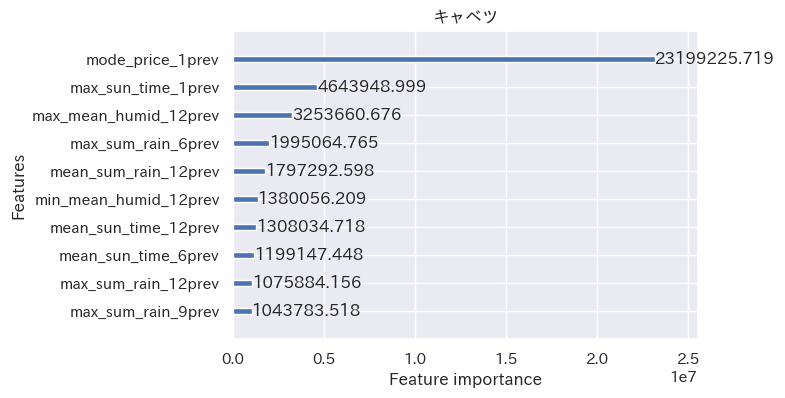

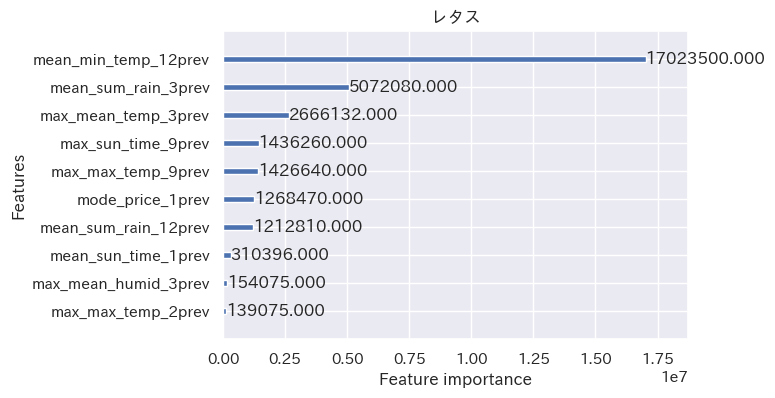

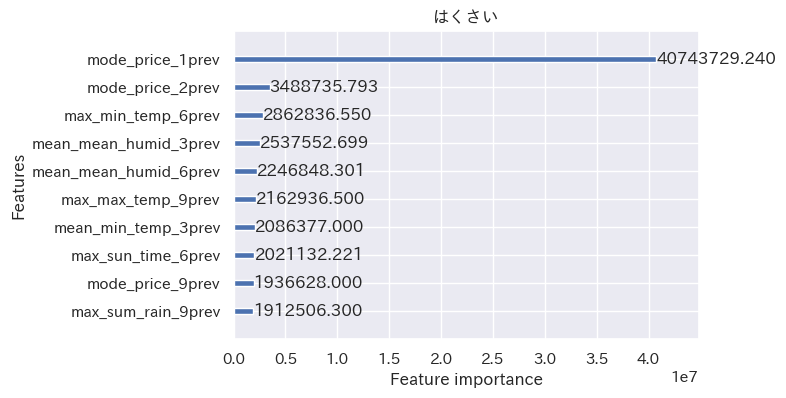

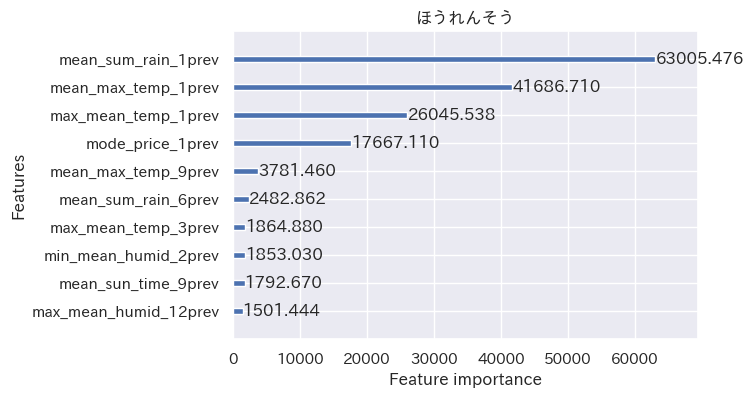

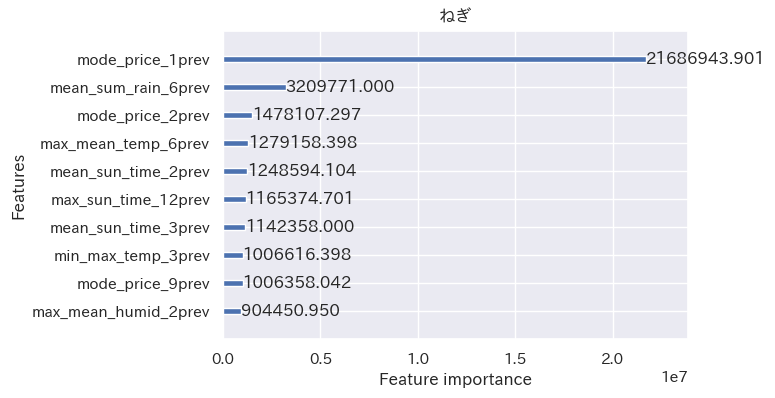

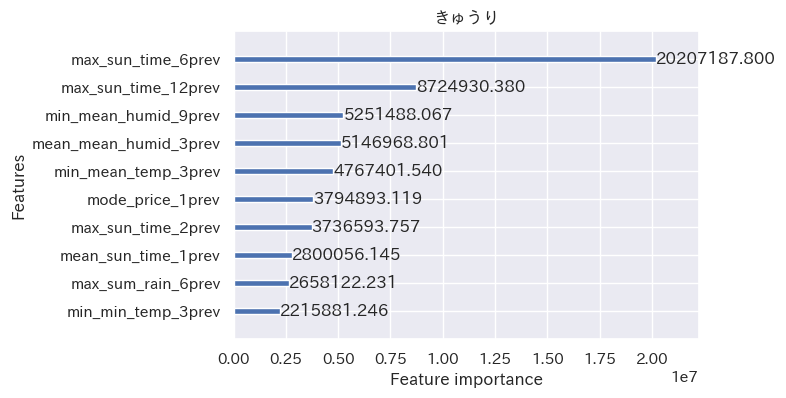

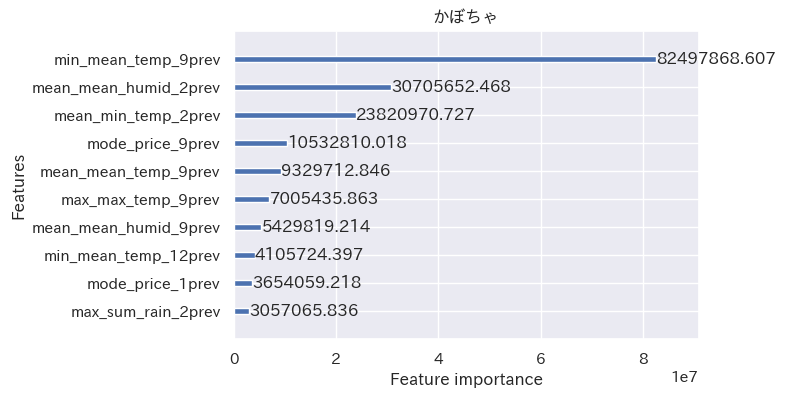

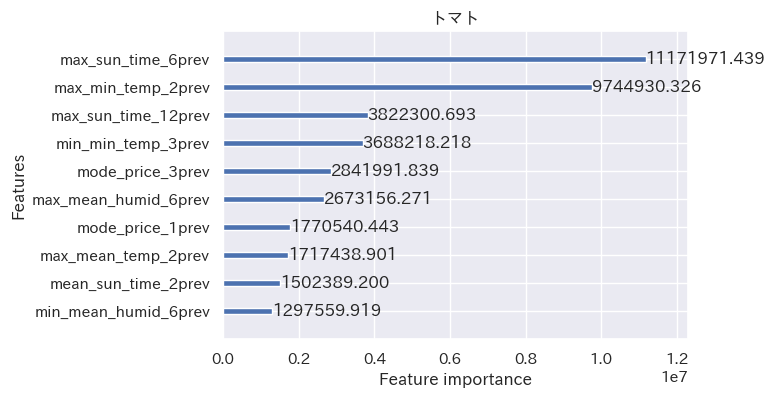

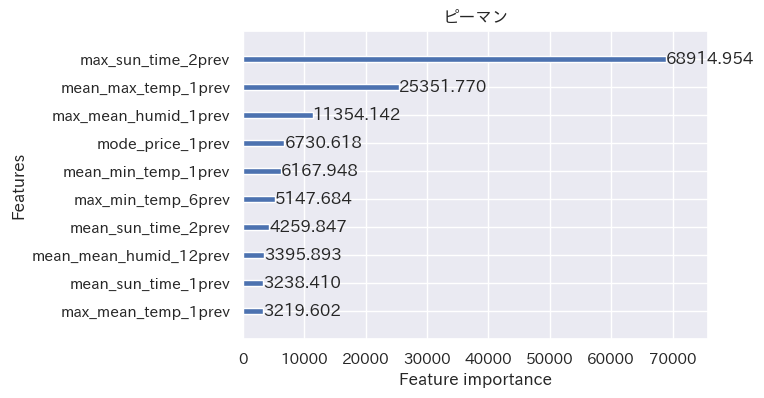

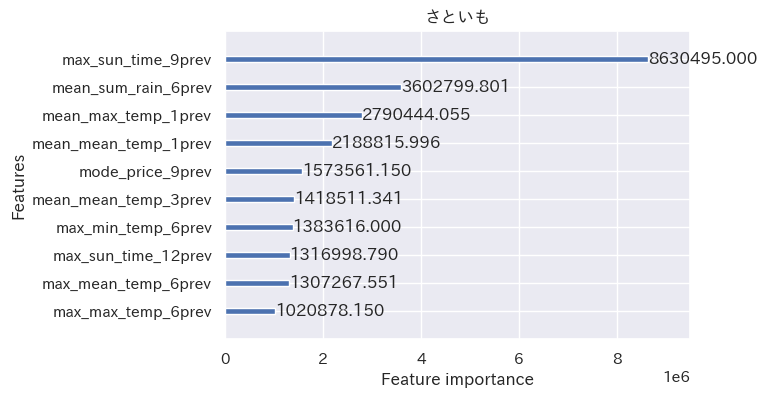

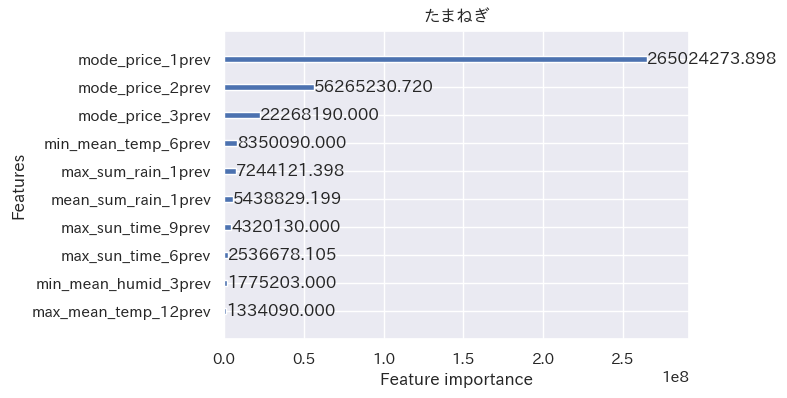

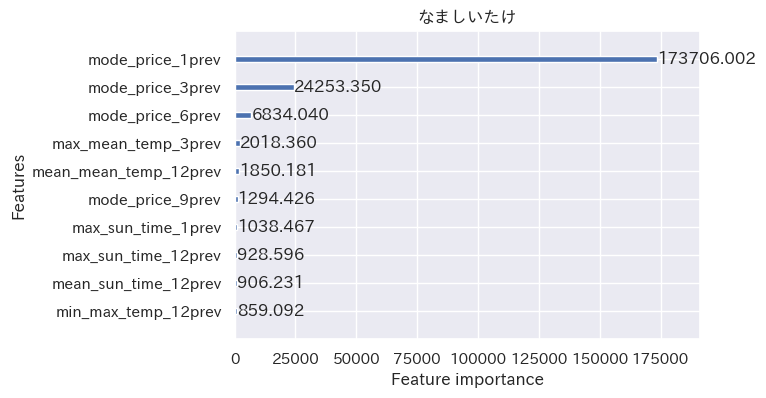

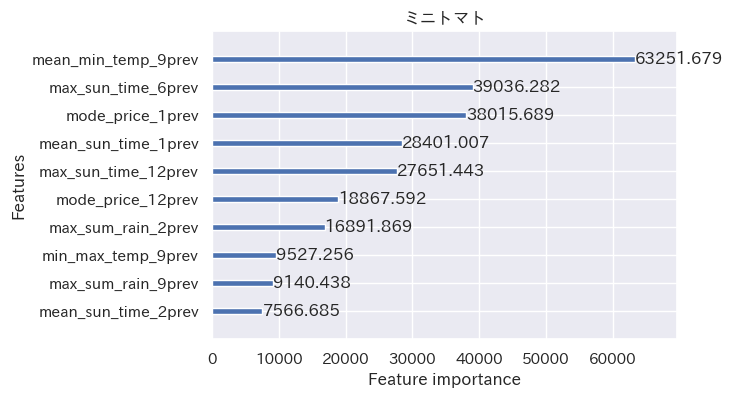

In [ ]:
for kind in kinds:
    model = model_dict[kind]
    lgb.plot_importance(model, figsize=(6,4), max_num_features=10, importance_type='gain', title=kind)
plt.show()
plt.close()

submissionファイルを作成します

In [ ]:
result_df = pd.DataFrame(result, columns=['kind','year','month',TARGET])

sub_df = pd.read_csv('sample_submission.csv')
sub_df.drop(TARGET, axis=1, inplace=True)
sub_df['year'] = sub_df['date'].apply(lambda x: int(str(x)[:4]))
sub_df['month'] = sub_df['date'].apply(lambda x: int(str(x)[4:6]))
sub_df = pd.merge(sub_df, result_df, on=['kind','year','month'], how='left')
sub_df.drop(['year','month'], axis=1, inplace=True)
sub_df.columns = ['kind', 'date', f'model_{TARGET}']
sub_df.head()

,kind,date,model_mode_price
0,だいこん,20221101,973.299454
1,だいこん,20221102,973.299454
2,だいこん,20221104,973.299454
3,だいこん,20221105,973.299454
4,だいこん,20221107,973.299454


validationデータを使って、評価値をルールベースとモデルベースで比較します

In [ ]:
data = []

for kind in sub_df['kind'].unique():
    actual = pred_df_dict[kind]['actual'][0]
    model_pred = pred_df_dict[kind]['predict'][0]
    rule_pred = tra_df_dict[kind][[TARGET]].iat[-1,0]
    data.append([kind, 20221001, actual, model_pred, rule_pred])

score_df = pd.DataFrame(data, columns=['kind','date','mode_price','model_mode_price','rule_mode_price'])

def _calc_model_metric(row):
    return np.sqrt(np.mean(((row['model_mode_price'] - row['mode_price']) / row['mode_price'])**2))*100

def _calc_rule_metric(row):
    return np.sqrt(np.mean(((row['rule_mode_price'] - row['mode_price']) / row['mode_price'])**2))*100

score_df['pct_model'] = score_df.apply(_calc_model_metric, axis=1)
score_df['pct_rule'] = score_df.apply(_calc_rule_metric, axis=1)
score_df['pct_diff'] = score_df['pct_rule'] - score_df['pct_model']
score_df.drop_duplicates().sort_values('pct_diff', ascending=False)

,kind,date,mode_price,model_mode_price,rule_mode_price,pct_model,pct_rule,pct_diff
0,だいこん,20221001,999.000000,1017.465420,1388.571429,1.848390,38.996139,37.147749
4,はくさい,20221001,1143.818182,1143.615914,1380.857143,0.017684,20.723483,20.705799
7,きゅうり,20221001,1909.636364,1900.965211,1522.285714,0.454074,20.284000,19.829927
5,ほうれんそう,20221001,116.159091,115.919018,139.380952,0.206676,19.991428,19.784753
1,にんじん,20221001,1602.818182,1609.186801,1900.285714,0.397339,18.559032,18.161693
12,たまねぎ,20221001,4015.636364,4049.719932,4757.142857,0.848771,18.465479,17.616708
2,キャベツ,20221001,697.090909,760.332997,866.571429,9.072287,24.312542,15.240255
11,さといも,20221001,3244.909091,3244.878080,3595.764706,0.000956,10.812494,10.811539
6,ねぎ,20221001,1674.000000,1820.340422,1931.142857,8.741961,15.360983,6.619022
3,レタス,20221001,1693.636364,1739.323177,1548.000000,2.697557,8.599034,5.901476


In [ ]:
OUTPUT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/cpt-yasai/data/output")
OUTPUT_DIR.mkdir(exist_ok=True)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/cpt-yasai/data/output'

In [ ]:
rule_sub_df.rename(columns={'rule_mode_price':'mode_price'}).to_csv(OUTPUT_DIR/'tutorial_rule_submission.csv', index=False)
sub_df.rename(columns={'model_mode_price':'mode_price'}).to_csv(OUTPUT_DIR/'tutorial_test_submission.csv', index=False)